In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
data_directory = r'C:\Users\Dell\Downloads\SCD_Daset\train'


In [4]:
if not os.path.exists(data_directory):
    print(f"The directory '{data_directory}' does not exist.")
else:
    # List the contents of the directory
    contents = os.listdir(data_directory)
    print("Contents of the directory:")
    for item in contents:
        print(item)

Contents of the directory:
benign
malignant


In [5]:
class_labels = os.listdir(data_directory)
filepaths = []
labels = []

In [6]:
for label in class_labels:
    label_directory = os.path.join(data_directory, label)
    for image_filename in os.listdir(label_directory):
        if image_filename.endswith(".jpg"):
            image_path = os.path.join(label_directory, image_filename)
            filepaths.append(image_path)
            labels.append(label)

In [7]:
data = pd.DataFrame({
    'Filepath': filepaths,
    'Label': labels
})


In [8]:
data = data.sample(frac=1).reset_index(drop=True)

In [9]:
print(data.head(5))

                                            Filepath      Label
0  C:\Users\Dell\Downloads\SCD_Daset\train\malign...  malignant
1  C:\Users\Dell\Downloads\SCD_Daset\train\malign...  malignant
2  C:\Users\Dell\Downloads\SCD_Daset\train\malign...  malignant
3  C:\Users\Dell\Downloads\SCD_Daset\train\malign...  malignant
4  C:\Users\Dell\Downloads\SCD_Daset\train\malign...  malignant


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


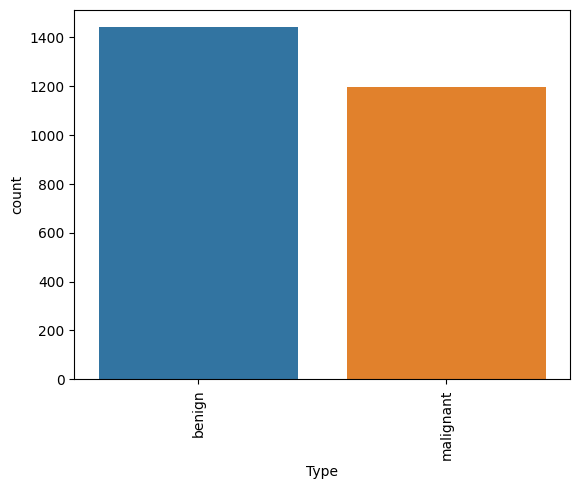

In [10]:
counts = data['Label'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['Filepath'], data['Label'], test_size=0.2, random_state=42)

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [13]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=data,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=data,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2637 validated image filenames belonging to 2 classes.
Found 2637 validated image filenames belonging to 2 classes.


In [14]:
pretrained_model = ResNet50(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [15]:
pretrained_model.trainable = False

In [16]:
inputs = tf.keras.layers.Input(shape=(100, 100, 3))
x = pretrained_model(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    mode='auto'
)

In [19]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,  # You can adjust the number of epochs
    callbacks=[early_stopping]
)

Epoch 1/10
83/83 [==============================] - 138s 2s/step - loss: 0.4173 - accuracy: 0.7979 - val_loss: 0.3573 - val_accuracy: 0.8324
Epoch 2/10
83/83 [==============================] - 135s 2s/step - loss: 0.2983 - accuracy: 0.8616 - val_loss: 0.2331 - val_accuracy: 0.8915
Epoch 3/10
83/83 [==============================] - 133s 2s/step - loss: 0.2518 - accuracy: 0.8813 - val_loss: 0.2030 - val_accuracy: 0.9166
Epoch 4/10
83/83 [==============================] - 130s 2s/step - loss: 0.2096 - accuracy: 0.9033 - val_loss: 0.1735 - val_accuracy: 0.9245
Epoch 5/10
83/83 [==============================] - 130s 2s/step - loss: 0.1999 - accuracy: 0.9082 - val_loss: 0.2424 - val_accuracy: 0.8790
Epoch 6/10
83/83 [==============================] - 129s 2s/step - loss: 0.1617 - accuracy: 0.9287 - val_loss: 0.1087 - val_accuracy: 0.9598
Epoch 7/10
83/83 [==============================] - 130s 2s/step - loss: 0.1182 - accuracy: 0.9492 - val_loss: 0.0812 - val_accuracy: 0.9765
Epoch 8/10
83

In [20]:
results = model.evaluate(test_gen, verbose=0)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1] * 100, "%")

Test Loss: 0.07841233909130096
Test Accuracy: 97.49715328216553 %


In [21]:
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)

83/83 [==============================] - 90s 1s/step


In [22]:
test_labels = (y_test == 'malignant').astype(int)

In [24]:
model.save("model_resnet50.h5")

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

In [29]:
img_path = '6.jpg'

In [30]:
img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

In [31]:
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)


In [32]:
loaded_model_resnet = load_model("model_resnet50.h5")

In [33]:
result = loaded_model_resnet.predict(x)

1/1 [==============================] - 1s 1s/step


In [34]:
index = np.argmax(result)

In [35]:
name_class = ['benign', 'malignant']

In [36]:
predicted_class = name_class[index]

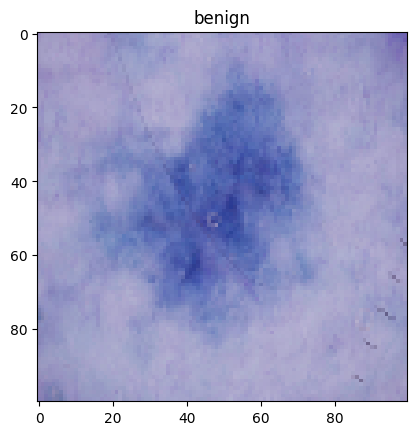

In [37]:
plt.title(predicted_class)
plt.imshow(img)
plt.show()